In [2]:
%matplotlib widget

import torch
from ptbxlae.modeling.convolutionalVAE import ConvolutionalEcgVAE
from ptbxlae.dataprocessing.cachedDS import SingleCycleCachedDS
import matplotlib.pyplot as plt
from ipywidgets import *
import numpy as np


In [3]:
torch.no_grad()
m = ConvolutionalEcgVAE.load_from_checkpoint('../cache/savedmodels/scc-epoch=057-val_loss=0.019016.ckpt')
m = m.eval()
m

ConvolutionalEcgVAE(
  (encoder): ConvolutionalEcgEncoder(
    (net): Sequential(
      (0): Conv1d(12, 24, kernel_size=(13,), stride=(2,), padding=(6,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv1d(24, 48, kernel_size=(13,), stride=(2,), padding=(6,))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Flatten(start_dim=1, end_dim=-1)
      (5): Linear(in_features=6000, out_features=1500, bias=True)
      (6): LeakyReLU(negative_slope=0.01)
    )
  )
  (decoder): ConvolutionalEcgDecoder(
    (net): Sequential(
      (0): Linear(in_features=40, out_features=1500, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=1500, out_features=6000, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Unflatten(dim=1, unflattened_size=(48, 125))
      (5): ConvTranspose1d(48, 24, kernel_size=(13,), stride=(2,), padding=(6,), output_padding=(1,))
      (6): LeakyReLU(negative_slope=0.01)
      (7): ConvTranspose1d(24, 12, kernel_size=(13,),

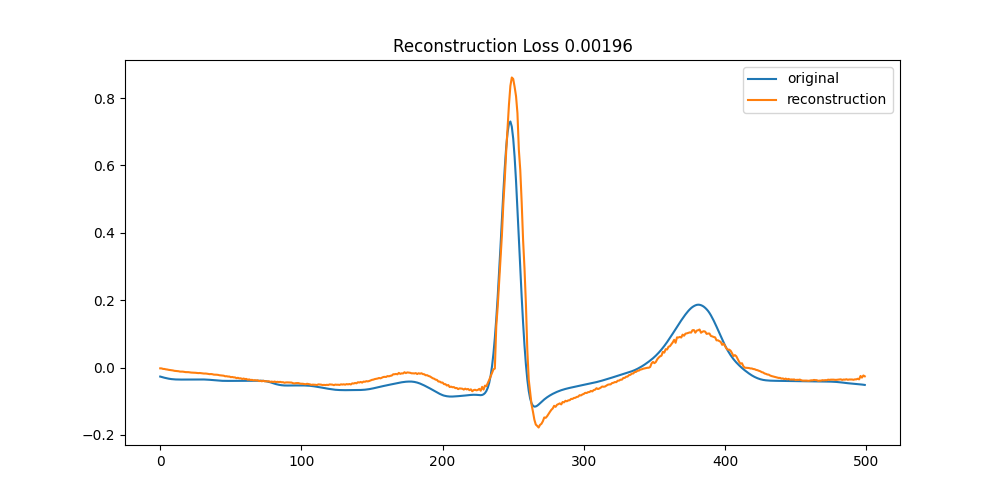

In [26]:
from torch.nn.functional import mse_loss

SAMPLE_IDX = 90
CHANNEL = 10
ds = SingleCycleCachedDS(cache_path="../cache/singlecycle_data", randomness=False)

latent_representation = m.encode(ds[SAMPLE_IDX].unsqueeze(0).to('cuda'))
# reconstruction = m.generate(latent_representation, smoothing_iterations=10).squeeze().detach().cpu()
reconstruction = m.decode(latent_representation).squeeze().detach().cpu()
orig_plot = ds[SAMPLE_IDX][CHANNEL]
recon_plot = reconstruction[CHANNEL]

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
ax.set_title(f"Reconstruction Loss {mse_loss(orig_plot, recon_plot):.5f}")
ax.plot(range(0, 500), orig_plot, label='original')
ax.plot(range(0, 500), recon_plot, label='reconstruction')
plt.legend(loc='best')

# ax1.set_title('Original')
# ax2.set_title('Reconstruction')

In [13]:
latent_representation

tensor([[ 0.3747, -1.4607, -0.7645,  0.1885, -0.6280,  0.7389,  0.6552,  0.4336,
         -0.3445,  1.7029,  2.0357, -0.0675,  0.6760,  0.8450,  0.5920, -1.9341,
         -0.6640,  0.9454,  0.0666,  1.4153, -0.1460, -0.4421,  1.0530,  0.1123,
          0.8314,  1.2367,  0.5372,  0.3216,  1.2027,  0.2430, -1.2600,  0.2651,
          0.5649, -0.5839,  1.8454, -1.0440,  1.8516,  1.1207, -0.0736,  0.0418]],
       device='cuda:0', grad_fn=<AddBackward0>)

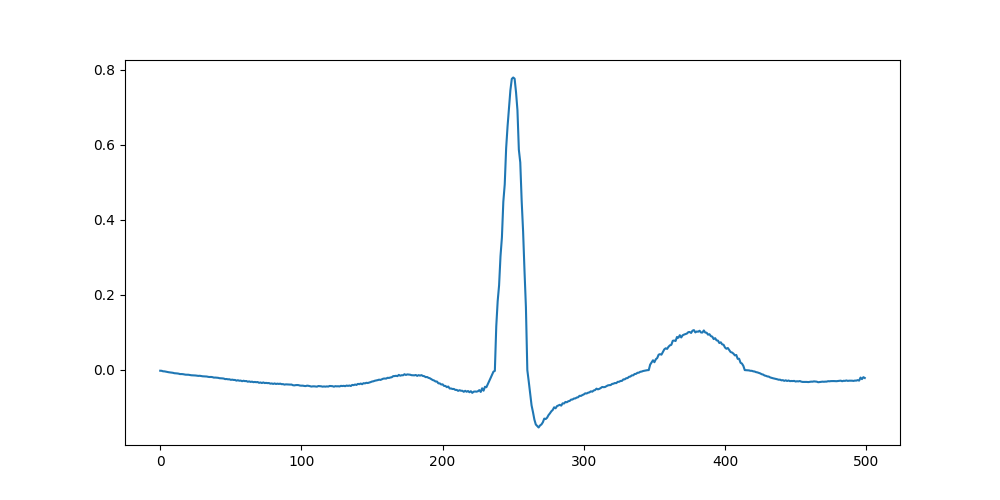

In [14]:

latent = (torch.rand_like(latent_representation) - 0.5) * 2
generated = m.decoder(latent.to('cuda')).squeeze().detach().cpu().numpy()

fig, ax = plt.subplots()
ax.plot(range(0, generated.shape[-1]), generated[CHANNEL])

interactive(children=(FloatSlider(value=-1.0, description='l', max=1.0, min=-3.0), Output()), _dom_classes=('w…

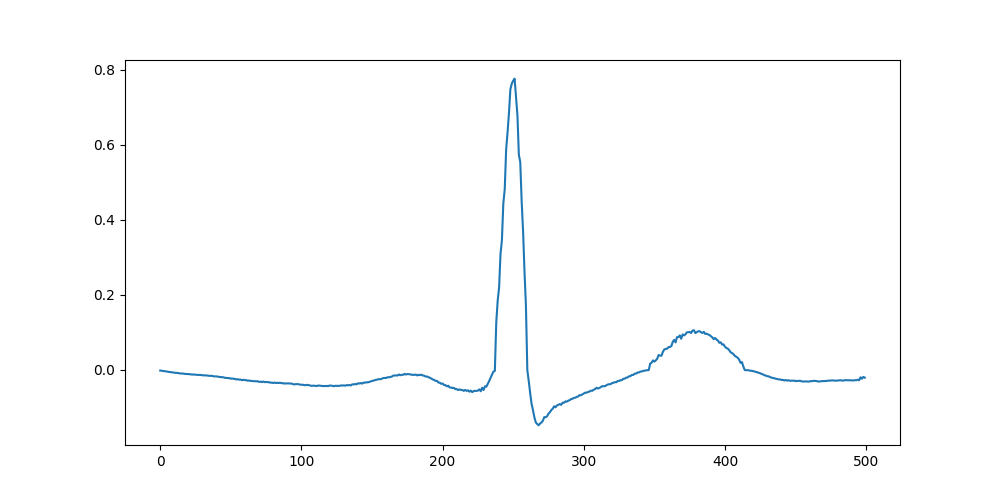

In [18]:
LATENT_FEATURE_IDX = 36
latent = (torch.rand_like(latent_representation) - 0.5) * 2


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(range(0, 500), generated[CHANNEL])

def update(l=-1.0):
    latent[0,LATENT_FEATURE_IDX] = l
    generated = m.decoder(latent.to('cuda')).squeeze().detach().cpu().numpy()
    line.set_ydata(generated[CHANNEL])
    fig.canvas.draw_idle()
    
interact(update);